In [1]:
library(Giotto)

In [2]:
sample_list <- c("151507", "151508", "151509",
               "151510", "151669", "151670",
               "151671", "151672", "151673",
               "151674", "151675", "151676")

In [3]:
base_path <- "/home/uqysun19/60days/Human_Brain_spatialLIBD/"

In [4]:
sample = sample_list[1]

In [6]:
input_path <- paste0(base_path, sample)
gt_path <- paste0(base_path, 
                  paste0(sample, 
                         paste0("/cluster_labels_",
                                paste0(sample, ".csv"))))
ground_truth_df <- read.csv(gt_path)
n_cluster <- length(unlist(unique(ground_truth_df["ground_truth"]))) - 1
results_path <- paste0("/home/uqysun19/60days/Human_Brain_spatialLIBD/other_clustering/Giotto_results/", sample)
dir.create(results_path, showWarnings = FALSE)

instrs = createGiottoInstructions(save_dir = results_path,
                                  save_plot = TRUE,
                                  show_plot = FALSE)

visium_data = createGiottoVisiumObject(h5_visium_path = paste0(input_path, '/filtered_feature_bc_matrix.h5'),
                                       h5_tissue_positions_path = paste0(input_path, '/spatial/tissue_positions_list.csv'),
                                       h5_image_png_path = paste0(input_path, '/spatial/tissue_hires_image.png'),
                                       gene_column_index = 2, instructions = instrs)


 no external python path or giotto environment was specified, will check if a default python path is available 

 A default python path was found:  /home/uqysun19/90days/.conda/envs/Giotto/bin/python3  and will be used

 If this is not the correct python path, either

 1. use installGiottoEnvironment() to install a local miniconda python environment along with required modules 

 2. provide an existing python path to python_path to use your own python path which has all modules installed 
A path to an .h5 10X file was provided and will be used 
Consider to install these (optional) packages to run all possible Giotto commands for spatial analyses:  scran MAST smfishHmrf trendsceek SPARK multinet RTriangle FactoMiner
 Giotto does not automatically install all these packages as they are not absolutely required and this reduces the number of dependencies


 first scale genes and then cells 


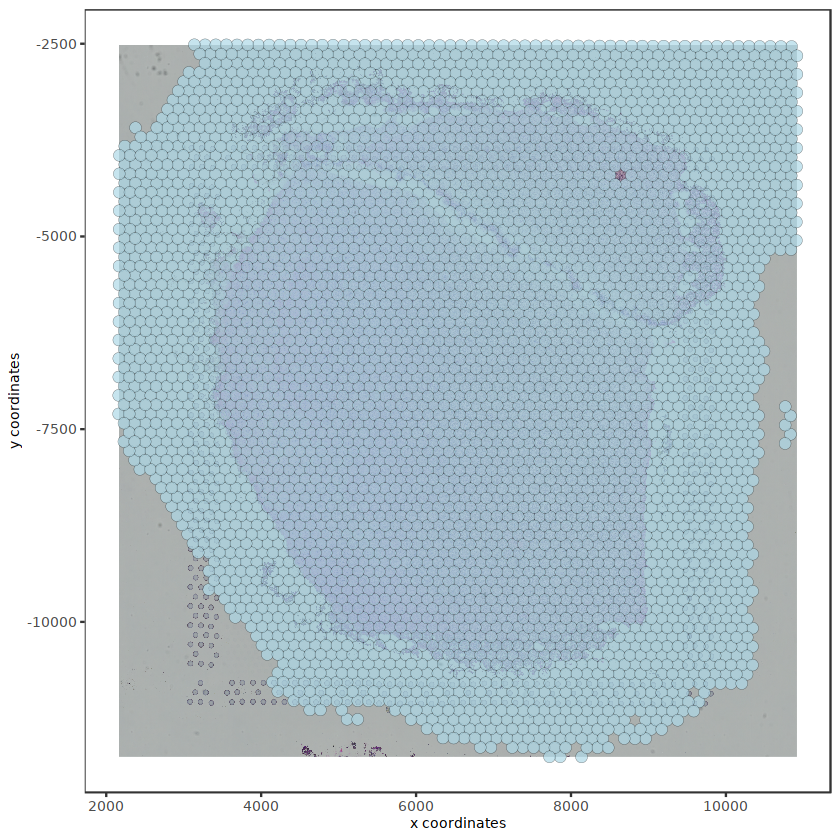

In [7]:
## subset on spots that were covered by tissue
metadata = pDataDT(visium_data)
in_tissue_barcodes = metadata[in_tissue == 1]$cell_ID
visium_data = subsetGiotto(visium_data, cell_ids = in_tissue_barcodes)

## filter
# visium_data <- filterGiotto(gobject = visium_data,
#                               expression_threshold = 1,
#                               gene_det_in_min_cells = 50,
#                               min_det_genes_per_cell = 1000,
#                               expression_values = c('raw'),
#                               verbose = T)

## normalize
visium_data <- normalizeGiotto(gobject = visium_data, scalefactor = 6000, verbose = T)

## add gene & cell statistics
visium_data <- addStatistics(gobject = visium_data)

## visualize
spatPlot2D(gobject = visium_data, show_image = T, point_alpha = 0.7,
           save_param = list(save_name = '2_d_spatial_locations'))

In [8]:
## highly variable genes (HVG)
visium_data <- calculateHVG(gobject = visium_data,
                              save_param = list(save_name = '3_a_HVGplot'))


Warning message:
“Removed 12387 rows containing missing values (geom_point).”


return_plot = TRUE and return_gobject = TRUE 

          plot will not be returned to object, but can still be saved with save_plot = TRUE or manually 


a custom vector of genes will be used to subset the matrix 
PCA with name:  pca  already exists and will be used for the screeplot 


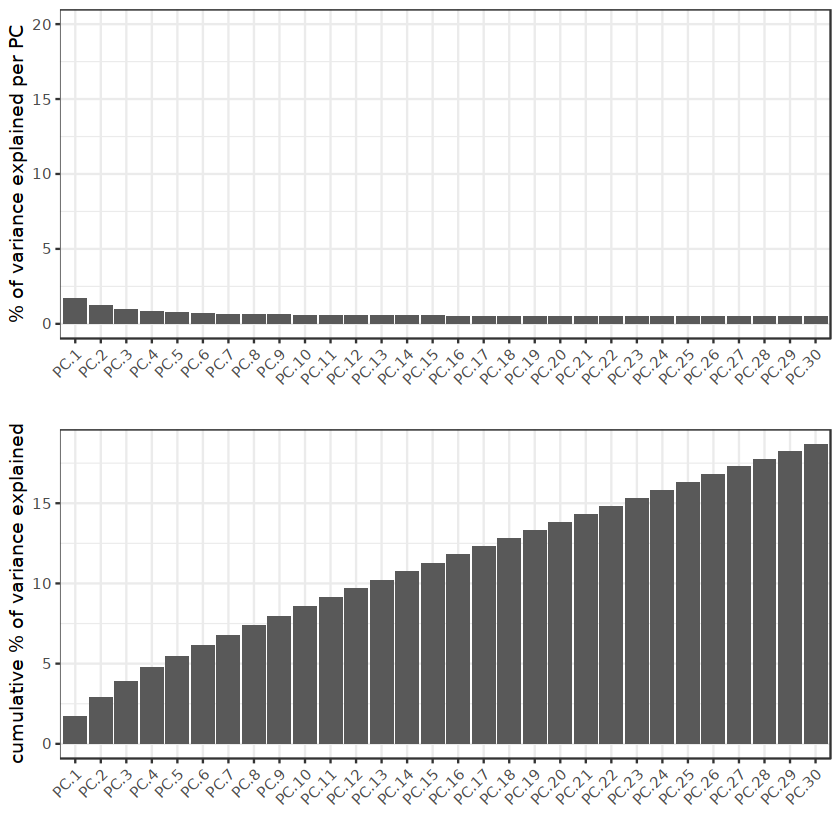

In [9]:
## run PCA on expression values (default)
gene_metadata = fDataDT(visium_data)
featgenes = gene_metadata[hvg == 'yes' & perc_cells > 3 & mean_expr_det > 0.4]$gene_ID

visium_data <- runPCA(gobject = visium_data, 
                       genes_to_use = featgenes, 
                       scale_unit = F, center = T, 
                       method="factominer")

screePlot(visium_data, ncp = 30, save_param = list(save_name = '3_b_screeplot'))

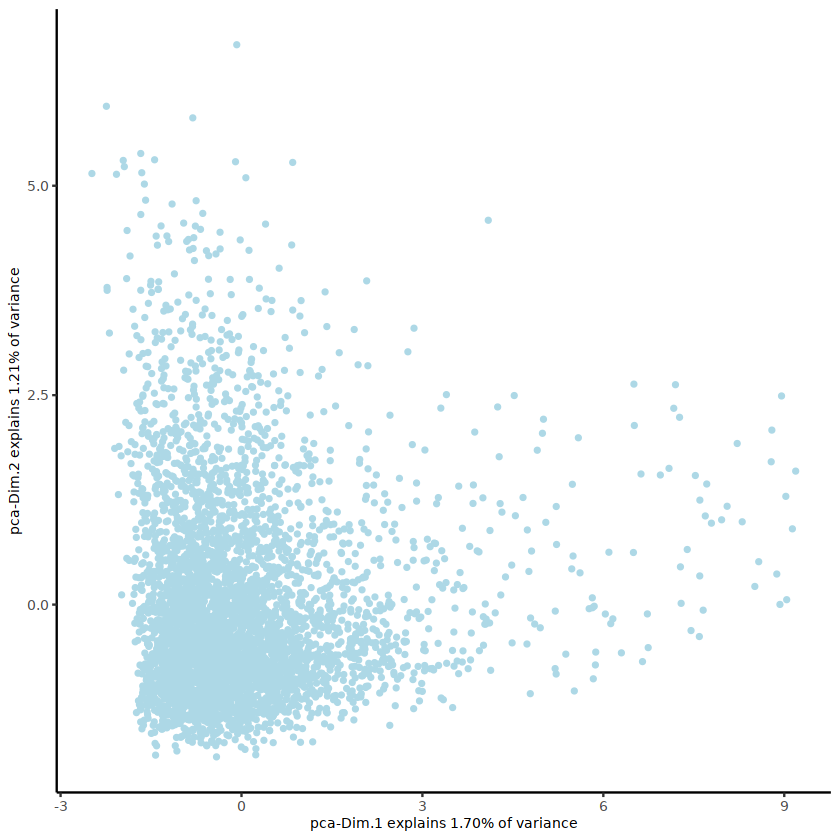

In [10]:
plotPCA(gobject = visium_data,
        save_param = list(save_name = '3_c_PCA_reduction'))

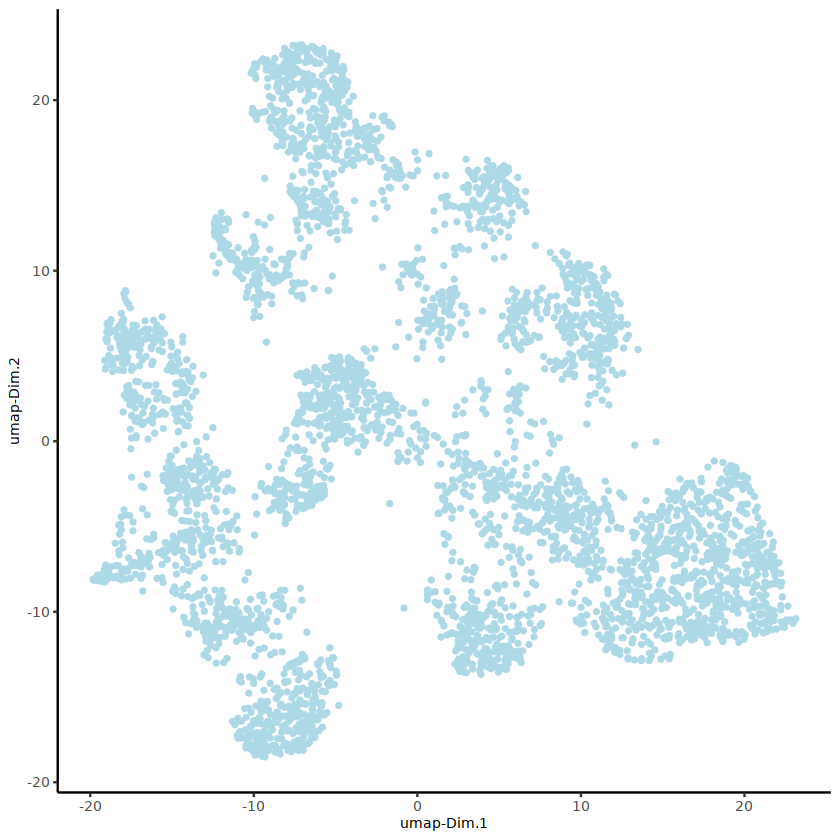

In [11]:
visium_data <- runUMAP(visium_data, dimensions_to_use = 1:10)
plotUMAP(gobject = visium_data,
         save_param = list(save_name = '3_d_UMAP_reduction'))

In [12]:
## sNN network (default)
visium_data <- createNearestNetwork(gobject = visium_data, dimensions_to_use = 1:10, k = 15)


In [16]:
res <- 0.1
for (i in 1:1000){
    visium_data <- doLeidenCluster(gobject = visium_data, resolution = res, n_iterations = 1000)
    n <- length(unique(visium_data@cell_metadata$leiden_clus))
    if (n > n_cluster) {
        res <- res - (i/1000)*5
    }
    if (n < n_cluster) {
        res <- res + (i/1000)*5
    }
    if (n == n_cluster) {
        print(res)
        break
    }
}


  leiden_clus  has already been used, will be overwritten 

  leiden_clus  has already been used, will be overwritten 

  leiden_clus  has already been used, will be overwritten 

  leiden_clus  has already been used, will be overwritten 
[1] 0.13


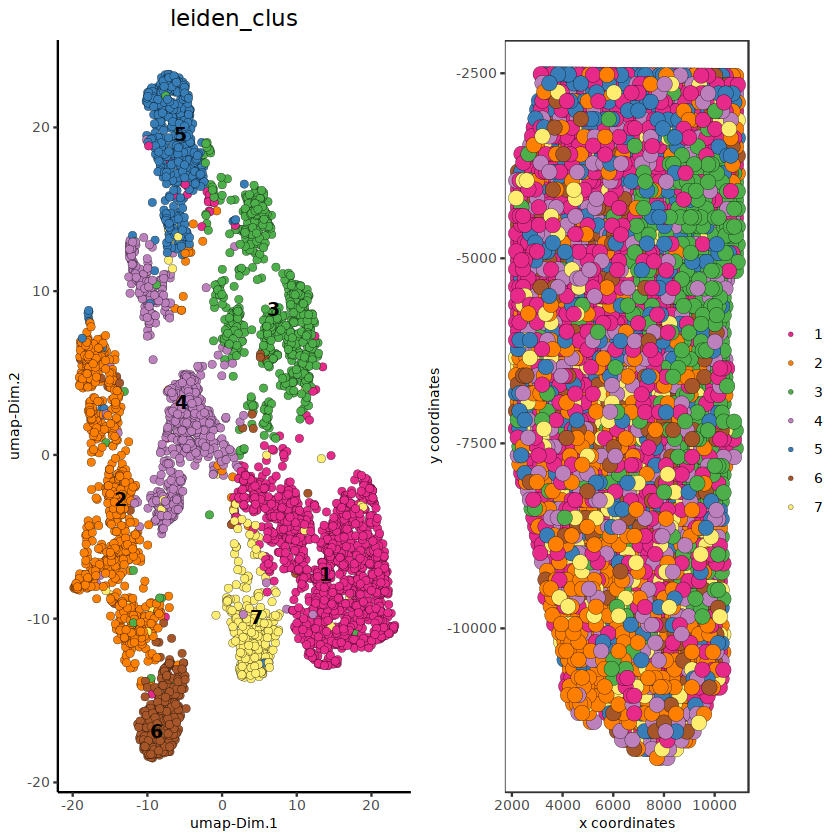

In [17]:
# expression and spatial
spatDimPlot(gobject = visium_data, cell_color = 'leiden_clus', plot_alignment="horizontal", spat_show_legend=T,
            dim_point_size = 2, spat_point_size = 4,
            save_param = list(save_name = '5_a_covis_leiden', base_width=20))